In [1]:
import pyodbc
import pandas as pd
import matplotlib.pyplot as plt
from config import SQLusername
from config import SQLpassword
import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier, plot_tree, plot_importance
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn import tree
pd.set_option('max_columns', None)

In [2]:
server = "cohort50sqlserver.database.windows.net" 
database = 'Illidans_Ingenious_Infrastructure' 
username = SQLusername 
password = SQLpassword  
cnxn = pyodbc.connect('DRIVER={SQL Server};SERVER='+server+';DATABASE='+database+';UID='+username+';PWD='+ password)
cursor = cnxn.cursor()
query = "SELECT * FROM dbo.boroughs_housing;"
df = pd.read_sql(query, cnxn)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1113589 entries, 0 to 1113588
Data columns (total 16 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   BOROUGH                    1113589 non-null  object        
 1   NEIGHBORHOOD               1113589 non-null  object        
 2   BUILDING CLASS CATEGORY    1113589 non-null  object        
 3   TAX CLASS AT PRESENT       1113589 non-null  object        
 4   BLOCK                      1113589 non-null  object        
 5   LOT                        1113589 non-null  object        
 6   ZIP CODE                   1113570 non-null  object        
 7   RESIDENTIAL UNITS          1113589 non-null  object        
 8   COMMERCIAL UNITS           1113589 non-null  object        
 9   TOTAL UNITS                1113589 non-null  object        
 10  LAND SQUARE FEET           647083 non-null   float64       
 11  GROSS SQUARE FEET          636337 non

In [11]:
# df['GROSS SQUARE FEET'].sort_values(ascending=True).head(20)

In [148]:
df['YEAR BUILT'] = pd.to_numeric(df['YEAR BUILT'])
df['BOROUGH'] = pd.to_numeric(df['BOROUGH'])
df['BLOCK'] = pd.to_numeric(df['BLOCK'])
df['LOT'] = pd.to_numeric(df['LOT'])

In [281]:
df['GROSS SQUARE FEET'].value_counts()

0.0         477254
112850.0     11238
2400.0        5340
1600.0        4669
1800.0        4643
             ...  
80844.0          1
55308.0          1
33358.0          1
66450.0          1
17498.0          1
Name: GROSS SQUARE FEET, Length: 19100, dtype: int64

In [280]:
# df[df['YEAR BUILT'].isna()]

In [254]:
qqq = df.copy()
counts = qqq['NEIGHBORHOOD'].value_counts()
idx = counts[counts.lt(5000)].index
qqq.loc[qqq['NEIGHBORHOOD'].isin(idx), ['NEIGHBORHOOD']] = 'OTHER'
# qqq[qqq['NEIGHBORHOOD']=='OTHER']
counts = qqq['BUILDING CLASS CATEGORY'].value_counts()
idx = counts[counts.lt(5000)].index
qqq.loc[qqq['BUILDING CLASS CATEGORY'].isin(idx), ['BUILDING CLASS CATEGORY']] = 'OTHER'
# qqq[qqq['BUILDING CLASS CATEGORY']=='OTHER']
counts = qqq['ZIP CODE'].value_counts()
idx = counts[counts.lt(5000)].index
qqq.loc[qqq['ZIP CODE'].isin(idx), ['ZIP CODE']] = 'OTHER'
# qqq[qqq['ZIP CODE']=='OTHER']
qqq['NEIGHBORHOOD'] = qqq['NEIGHBORHOOD'].str.strip()
# Use misc/other for dummy --- feature shape mismatch
# NEIGHBORHOOD < 100, BUILDING CLASS CATEGORY < 100, ZIP CODE < 100, maybe...YEAR BUILT
# %10 year built for decades
# Split sale date by year and month

In [233]:
# qqq[qqq['ZIP CODE']=='OTHER']

In [252]:
# qqq['NEIGHBORHOOD'].value_counts()

In [293]:
training_data = qqq.loc[(qqq['SALE DATE'] < '2018-01-01')]
test_data = qqq.loc[(qqq['SALE DATE'] >= '2018-01-01')]
test_data.reset_index(drop=True,inplace=True)

In [294]:
X_train = training_data[['BLOCK','LOT']]
# X_train = training_data[['SALE DATE']]
tmp = pd.get_dummies(training_data['NEIGHBORHOOD'], drop_first=True)
X_train = pd.concat([X_train, tmp], axis=1)
y_train = training_data[['SALE PRICE']]
X_test = test_data[['BLOCK','LOT']]
# X_test = test_data[['SALE DATE']]
tmp = pd.get_dummies(test_data['NEIGHBORHOOD'], drop_first=True)
X_test = pd.concat([X_test, tmp], axis=1)
y_test = test_data[['SALE PRICE']]

In [295]:
X_train

,BLOCK,LOT,BAY RIDGE,BAYSIDE,BEDFORD STUYVESANT,BOROUGH PARK,BUSHWICK,CANARSIE,CHELSEA,CORONA,CROWN HEIGHTS,EAST NEW YORK,ELMHURST,FINANCIAL,FLATBUSH-CENTRAL,FLATBUSH-EAST,FLUSHING-NORTH,FLUSHING-SOUTH,FOREST HILLS,GRAMERCY,GRAVESEND,GREAT KILLS,GREENWICH VILLAGE-CENTRAL,GREENWICH VILLAGE-WEST,HARLEM-CENTRAL,JACKSON HEIGHTS,LONG ISLAND CITY,MIDTOWN EAST,MIDTOWN WEST,MURRAY HILL,OCEAN HILL,OTHER,OZONE PARK,PARK SLOPE,PARKCHESTER,QUEENS VILLAGE,REGO PARK,RICHMOND HILL,RIVERDALE,SHEEPSHEAD BAY,SO. JAMAICA-BAISLEY PARK,SOUTH JAMAICA,SOUTH OZONE PARK,SPRINGFIELD GARDENS,ST. ALBANS,SUNSET PARK,TRIBECA,UPPER EAST SIDE (59-79),UPPER EAST SIDE (79-96),UPPER WEST SIDE (59-79),UPPER WEST SIDE (79-96),UPPER WEST SIDE (96-116)
0,478,1040,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,375,32,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,552,64,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1011,4265,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,492,1008,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
920410,7317,136,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
920411,7349,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
920412,7349,78,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
920413,7351,60,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [296]:
X_test

,BLOCK,LOT,GREENWICH VILLAGE-CENTRAL,OTHER
0,877,1052,0,1
1,877,1076,0,1
2,877,1082,0,1
3,879,1014,0,1
4,879,1032,0,1
...,...,...,...,...
193312,3793,56,0,1
193313,3793,57,0,1
193314,3796,6,0,1
193315,3796,8,0,1


In [292]:
xgb_model = XGBRegressor(n_estimators = 100, eta = 0.1, objective='reg:squarederror',random_state=0, max_depth = 6)
xgb_model.fit(X_train, y_train)
print("Training set accuracy score:",xgb_model.score(X_train,y_train))
y_pred = xgb_model.predict(X_test.values)
print("Test set accuracy score:",xgb_model.score(X_test,y_test))

Training set accuracy score: 0.39001376428601553
Test set accuracy score: 0.1078997077881263


In [40]:
# reg = xgb.XGBRegressor(n_estimators=1000)
# reg.fit(X_train, y_train,
#         eval_set=[(X_train, y_train), (X_test, y_test)],
#         early_stopping_rounds=50,
#        verbose=False)

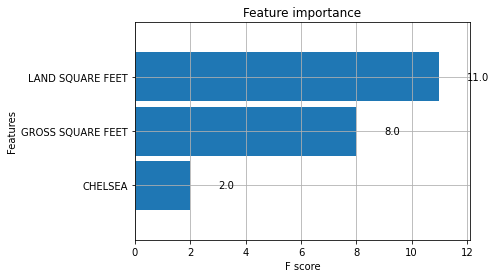

In [210]:
_ = plot_importance(xgb_model, height=0.9)